In [12]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
sns.set()


from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [13]:
# importing the data
merged_clean = pd.read_csv("merged_clean.csv")

In [14]:
merged_clean1 = merged_clean
label = preprocessing.LabelEncoder()
#data_encoded = pd.DataFrame() 

for i in ['vehicle_type', 'vehicle_leaving_carriageway', 'local_authority_district', 'urban_or_rural_area'] :
    merged_clean1[i]=label.fit_transform(merged_clean1[i])
    
#merged_clean1['hour'] = pd.to_datetime(merged_clean1.time).dt.hour

In [15]:
X = merged_clean1[['vehicle_type', 'vehicle_leaving_carriageway', 'local_authority_district', 'urban_or_rural_area','age_of_driver', 'age_of_vehicle', 'number_of_vehicles', 'junction_control', 'hour','Month_no']]
y = merged_clean1['accident_severity']

In [16]:
# split data into train and test 
train_x,test_x,train_y,test_y = train_test_split(X,y,random_state=33)

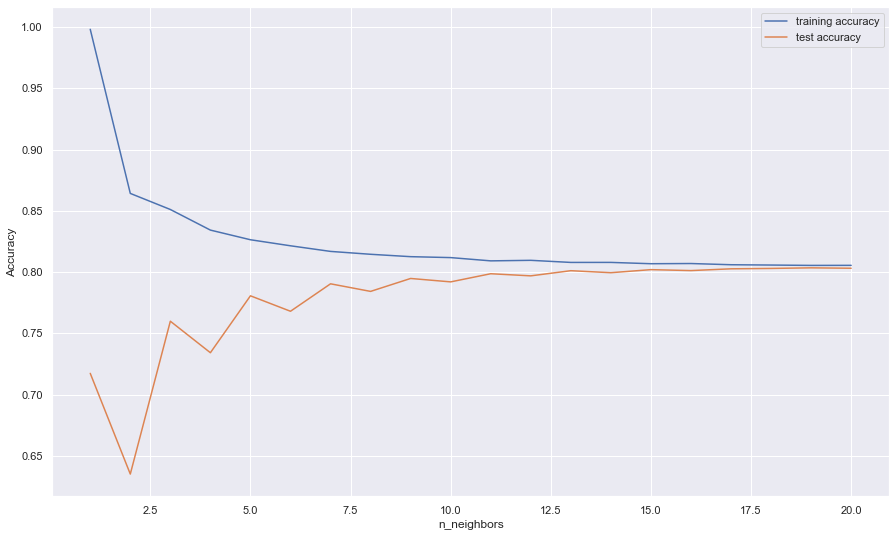

In [23]:
# hyper parameter tuning for KNN
# plot different k_neighbors
training_accuracy=[]
test_accuracy=[]
neighbors_settings=range(1,21)
for n_neighbors in neighbors_settings:
    clf=KNeighborsClassifier(n_neighbors=n_neighbors, metric="manhattan")
    clf.fit(train_x,train_y)
    training_accuracy.append(clf.score(train_x,train_y))
    test_accuracy.append(clf.score(test_x,test_y))
plt.figure(figsize=(15, 9))
plt.plot(neighbors_settings,training_accuracy,label="training accuracy")
plt.plot(neighbors_settings,test_accuracy,label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend();

kNN: 0.797292 (0.002900)
Naive Bayes: 0.783940 (0.003811)
DT: 0.701794 (0.003418)
RF: 0.804933 (0.002909)
AdaB: 0.803909 (0.002433)


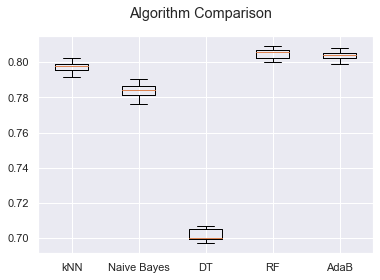

In [17]:
#prepare algorithms to test
models = []
models.append(('kNN', KNeighborsClassifier(n_neighbors = 13))) # n_neighbors optimized above
models.append(('Naive Bayes', GaussianNB()))
models.append(('DT', tree.DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(bootstrap=True, max_features='auto', n_estimators=50, max_depth=None,min_samples_split=5, random_state=7)))
models.append(('AdaB', AdaBoostClassifier()))


#evaluate each algorithm
results = []
names = []
for name, model in models:
    #If not statified, shuffle is vital given data is ordered by labels.
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring='accuracy',error_score='raise')
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    
#boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();
#plt.savefig('cross validation scores comparison.jpg', bbox_inches='tight', dpi=500);

In [18]:
# results dataframe
results_dico = {names[0]:results[0],names[1]:results[1],names[2]:results[2],names[3]:results[3],names[4]:results[4]}
results_df = pd.DataFrame(results_dico)
results_df

,kNN,Naive Bayes,DT,RF,AdaB
0,0.797382,0.784879,0.700278,0.804183,0.804036
1,0.798698,0.786926,0.698230,0.807327,0.805426
2,0.795700,0.781223,0.699985,0.801916,0.801843
3,0.799357,0.785244,0.705177,0.807546,0.805572
4,0.794092,0.783343,0.699400,0.801111,0.801331
5,0.799064,0.782831,0.707151,0.806303,0.804109
6,0.791752,0.776177,0.697061,0.800088,0.799137
7,0.802501,0.790728,0.704446,0.809374,0.807985
8,0.795759,0.780987,0.706252,0.804899,0.803803
9,0.798611,0.787057,0.699963,0.806581,0.805850


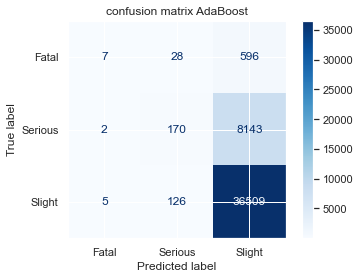

In [19]:
# Confusion matrix AdaBoost
ada_clf = AdaBoostClassifier()
ada_clf.fit(train_x, train_y)
plot_confusion_matrix(ada_clf,test_x,test_y,cmap=plt.cm.Blues)
plt.title("confusion matrix AdaBoost")
#plt.show();
plt.savefig('confusion matrix AdaBoost.jpg', bbox_inches='tight', dpi=500);

In [20]:
# F1-score for AdaBoost
ada_prediction=ada_clf.predict(test_x)
print(f1_score(test_y, ada_prediction, average='weighted'))

0.7241729531724674


In [21]:
# classification report for AdaBoost
target_names = ['class 0', 'class 1','class 2']
print(classification_report(test_y, ada_prediction, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.50      0.01      0.02       631
     class 1       0.52      0.02      0.04      8315
     class 2       0.81      1.00      0.89     36640

    accuracy                           0.80     45586
   macro avg       0.61      0.34      0.32     45586
weighted avg       0.75      0.80      0.72     45586



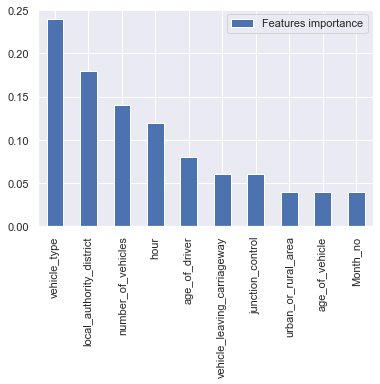

In [22]:
# Feature importance for AdaBoost
feature_importances_ada = pd.DataFrame(ada_clf.feature_importances_, index = list(train_x.columns), columns=['Features importance']).sort_values('Features importance', ascending=False)
feature_importances_ada.plot.bar();

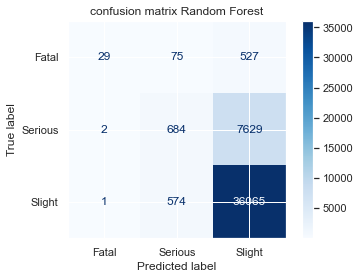

In [28]:
# Confusion matrix RF
RF_clf = RandomForestClassifier(bootstrap=True, max_features='auto', n_estimators=50, max_depth=None,min_samples_split=5, random_state=7)
RF_clf.fit(train_x, train_y)
plot_confusion_matrix(RF_clf,test_x,test_y,cmap=plt.cm.Blues)
plt.title("confusion matrix Random Forest")
plt.show();
#plt.savefig('confusion matrix Random Forest.jpg', bbox_inches='tight', dpi=500);

In [24]:
# F1-score for RF
prediction_RF=RF_clf.predict(test_x)
print(f1_score(test_y, prediction_RF, average='weighted'))

0.7440436526493739


In [25]:
# classification report for RF

target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(test_y, prediction_RF, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.91      0.05      0.09       631
     class 1       0.51      0.08      0.14      8315
     class 2       0.82      0.98      0.89     36640

    accuracy                           0.81     45586
   macro avg       0.74      0.37      0.37     45586
weighted avg       0.76      0.81      0.74     45586



<AxesSubplot:>

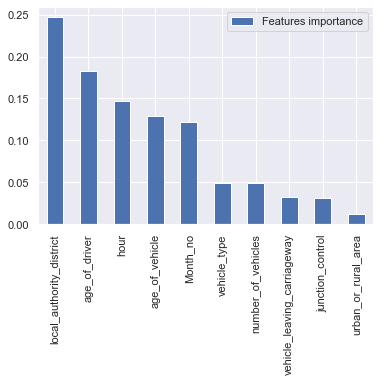

In [26]:
# Feature importance for RandomForest
feature_importances_RF = pd.DataFrame(RF_clf.feature_importances_, index = list(train_x.columns), columns=['Features importance']).sort_values('Features importance', ascending=False)
feature_importances_RF.plot.bar()